In [2]:
# Cell 1: Import required libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from sklearn.model_selection import train_test_split
import shutil

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.1


In [3]:
# Cell 2: Initialize TPU and set up strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None
    print('Not connected to a TPU runtime')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS:", strategy.num_replicas_in_sync)


Running on TPU: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1730624229.521472      13 service.cc:145] XLA service 0x5bca70d041e0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730624229.521523      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1730624229.521527      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1730624229.521530      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1730624229.521533      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1730624229.521536      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1730624229.521538      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1730624229.521541      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1730624229.521543      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
# Cell 3: Download and extract dataset
!pip install gdown
!gdown --id 17_KUaj9z0NSAODwE368_irCrnSOajSg- -O /kaggle/working/final_dataset2.zip

# Define the path to the zip file
zip_file_path = '/kaggle/working/final_dataset2.zip'
# Define the extraction path
extracted_data_path = '/kaggle/working'
# Unzip the file
!unzip -q {zip_file_path} -d {extracted_data_path}
# List the files to verify
!ls {extracted_data_path}


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
/usr/local/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17_KUaj9z0NSAODwE368_irCrnSOajSg-
From (redirected): https://drive.google.com/uc?id=17_KUaj9z0NSAODwE368_irCrnSOajSg-&confirm=t&uuid=7670eb6f-891a-42bf-8f42-12bd30a3caef
To: /kaggle/working/final_dataset2.zip
100%|█████████████████████████████████████████| 757M/757M [00:05<00:00, 128MB/s]
final_dataset  final_dataset2.zip


In [5]:
# Cell 4: Define dataset paths and split data into training and testing
DATASET_BASE_PATH = '/kaggle/working/final_dataset'
TRAIN_PATH = '/kaggle/working/train'
TEST_PATH = '/kaggle/working/test'

# Create directories for train and test split
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

for class_name in ['hc', 'pd', 'prodromal']:
    class_path = os.path.join(DATASET_BASE_PATH, class_name)
    train_class_path = os.path.join(TRAIN_PATH, class_name)
    test_class_path = os.path.join(TEST_PATH, class_name)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    
    # List all images in the class directory
    all_images = os.listdir(class_path)
    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
    
    # Move images to the corresponding train and test directories
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_path, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_path, img))

print(f"Data split into training and testing sets at {TRAIN_PATH} and {TEST_PATH}")

Data split into training and testing sets at /kaggle/working/train and /kaggle/working/test


In [6]:
# Cell 5: Load data using tf.data.Dataset
def load_data():
    BATCH_SIZE = 4 * strategy.num_replicas_in_sync  # Adjust as needed
    IMG_SIZE = (224, 224)

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_PATH,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True
    )

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_PATH,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False
    )

    return train_dataset, test_dataset

In [7]:
# Cell 6: Load data and output number of images in each set
train_dataset, test_dataset = load_data()

# Get class names and number of classes
class_names = train_dataset.class_names if hasattr(train_dataset, 'class_names') else ['hc', 'pd', 'prodromal']
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

# Output number of images in each dataset
train_image_count = sum([len(files) for r, d, files in os.walk(TRAIN_PATH)])
test_image_count = sum([len(files) for r, d, files in os.walk(TEST_PATH)])

print(f"Number of training images: {train_image_count}")
print(f"Number of test images: {test_image_count}")



Found 46021 files belonging to 3 classes.
Found 11506 files belonging to 3 classes.
Class names: ['hc', 'pd', 'prodromal']
Number of classes: 3
Number of training images: 46022
Number of test images: 11506


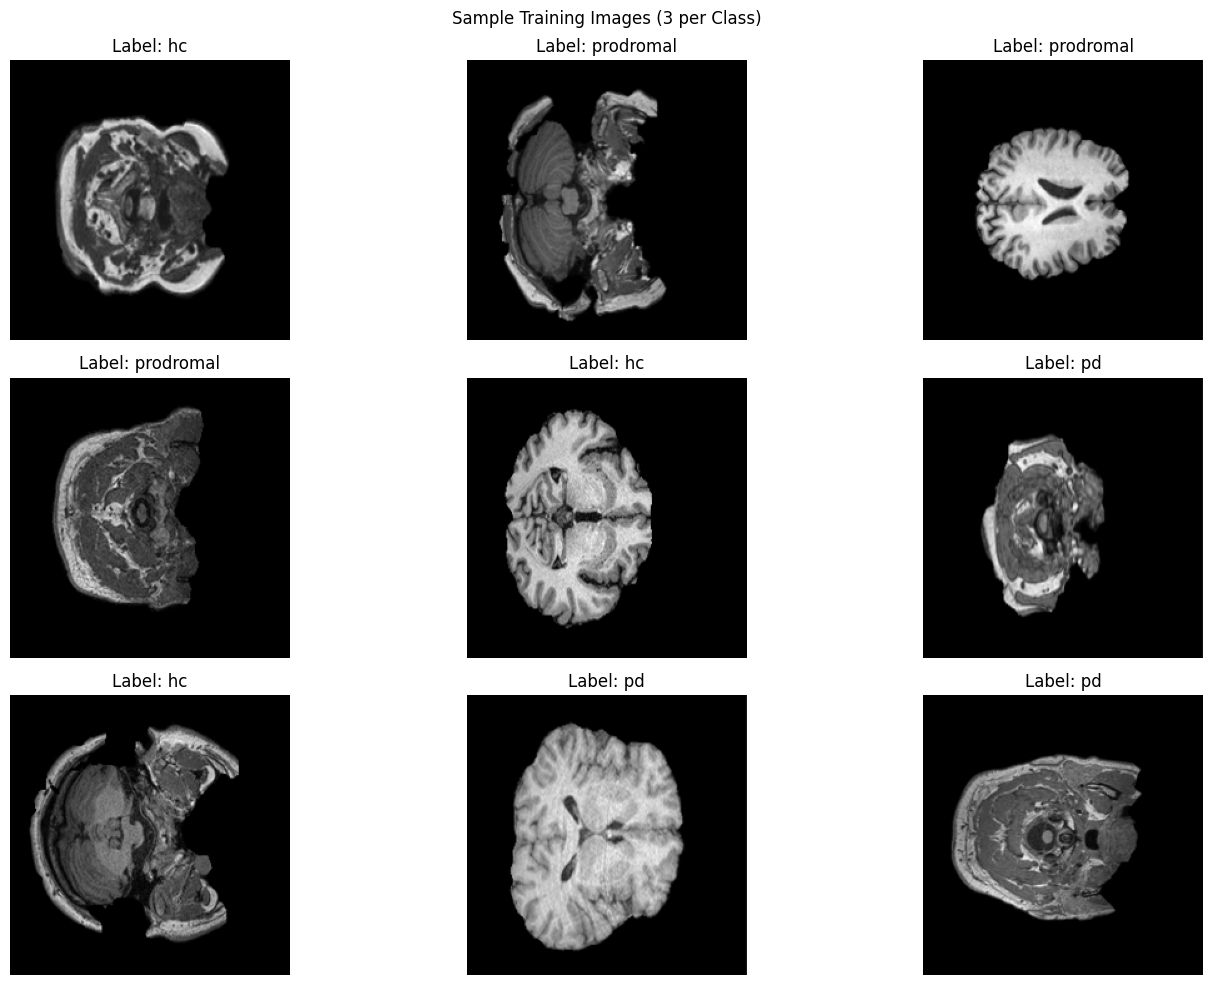

In [8]:
# Cell 7: Data verification - Display 9 images

# Ensure train_dataset is defined by loading the data
if 'train_dataset' not in globals() or 'class_names' not in globals():
    train_dataset, test_dataset = load_data()
    class_names = train_dataset.class_names

def display_sample_images(dataset, class_names):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        num_classes = len(class_names)
        class_counts = {i: 0 for i in range(num_classes)}
        images_displayed = 0
        for idx in range(len(images)):
            class_idx = tf.argmax(labels[idx]).numpy()
            if class_counts[class_idx] < 3:
                plt.subplot(3, 3, images_displayed + 1)
                plt.imshow(images[idx].numpy().astype("uint8"))
                plt.title(f"Label: {class_names[class_idx]}")
                plt.axis('off')
                class_counts[class_idx] += 1
                images_displayed += 1
            if images_displayed == 9:
                break
    plt.suptitle('Sample Training Images (3 per Class)')
    plt.tight_layout()
    plt.show()

display_sample_images(train_dataset, class_names)

In [9]:
# Cell 8: Build the Ensemble Model using ResNet50 and EfficientNet with the Added Dense(128) Layer

# Regularization factor
from tensorflow.keras.regularizers import l2
regularization = l2(0.0001)

with strategy.scope():
    # Input layer
    input_tensor = Input(shape=(224, 224, 3))
    
    # First base model: ResNet50
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model_resnet.trainable = False  # Freeze ResNet50
    
    x1 = base_model_resnet.output
    x1 = GlobalAveragePooling2D()(x1)
    
    # Second base model: EfficientNetB0
    base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
    base_model_efficientnet.trainable = False  # Freeze EfficientNetB0
    
    x2 = base_model_efficientnet.output
    x2 = GlobalAveragePooling2D()(x2)
    
    # Concatenate features
    concatenated = Concatenate()([x1, x2])
    
    # Add fully connected layers
    x = Dense(1024, activation='relu', kernel_regularizer=regularization)(concatenated)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.05)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.025)(x)

    
    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # Create the ensemble model
    model = Model(inputs=input_tensor, outputs=output_layer)
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    # Display the model summary
    model.summary()


I0000 00:00:1730624302.951125      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 31,745,638 (121.10 MB)

 Trainable params: 4,108,355 (15.67 MB)

 Non-trainable params: 27,637,283 (105.43 MB)

In [10]:
# Cell 9: Training the model
EPOCHS = 100  # Define the number of epochs

# Define callbacks (optional)
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1)
]

with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        verbose=2,
        callbacks=callbacks
    )

    # Save the model with a timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_save_path_with_timestamp = os.path.join(DATASET_BASE_PATH, f"ensemble_model_{timestamp}.h5")

    # Save the model
    model.save(model_save_path_with_timestamp)
    print(f"Model saved to: {model_save_path_with_timestamp}")


Epoch 1/100


2024-11-03 08:59:18.024289: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1730624359.793690     817 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ded761ff5d23f694:0:0), session_name()
I0000 00:00:1730624394.753891     817 tpu_compile_op_common.cc:245] Compilation of ded761ff5d23f694:0:0 with session name  took 34.960155048s and succeeded
I0000 00:00:1730624394.871980     817 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ded761ff5d23f694:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3493351619145872144", property.function_library_fingerprint = 10325842935849772645, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z 

1439/1439 - 127s - 88ms/step - accuracy: 0.4293 - auc: 0.6219 - loss: 1.3148 - precision: 0.5029 - recall: 0.1347 - learning_rate: 1.0000e-04
Epoch 2/100
1439/1439 - 48s - 33ms/step - accuracy: 0.5347 - auc: 0.7319 - loss: 1.1573 - precision: 0.5928 - recall: 0.3426 - learning_rate: 1.0000e-04
Epoch 3/100
1439/1439 - 49s - 34ms/step - accuracy: 0.5828 - auc: 0.7817 - loss: 1.0556 - precision: 0.6363 - recall: 0.4455 - learning_rate: 1.0000e-04
Epoch 4/100
1439/1439 - 48s - 33ms/step - accuracy: 0.6110 - auc: 0.8083 - loss: 0.9853 - precision: 0.6629 - recall: 0.5083 - learning_rate: 1.0000e-04
Epoch 5/100
1439/1439 - 48s - 33ms/step - accuracy: 0.6595 - auc: 0.8440 - loss: 0.8989 - precision: 0.7032 - recall: 0.5766 - learning_rate: 1.0000e-04
Epoch 6/100
1439/1439 - 49s - 34ms/step - accuracy: 0.6720 - auc: 0.8550 - loss: 0.8625 - precision: 0.7121 - recall: 0.6016 - learning_rate: 1.0000e-04
Epoch 7/100
1439/1439 - 49s - 34ms/step - accuracy: 0.7052 - auc: 0.8812 - loss: 0.7884 - pre

Model saved to: /kaggle/working/final_dataset/ensemble_model_20241103_102125.h5


Training history plot saved to: /kaggle/working/training_history.png


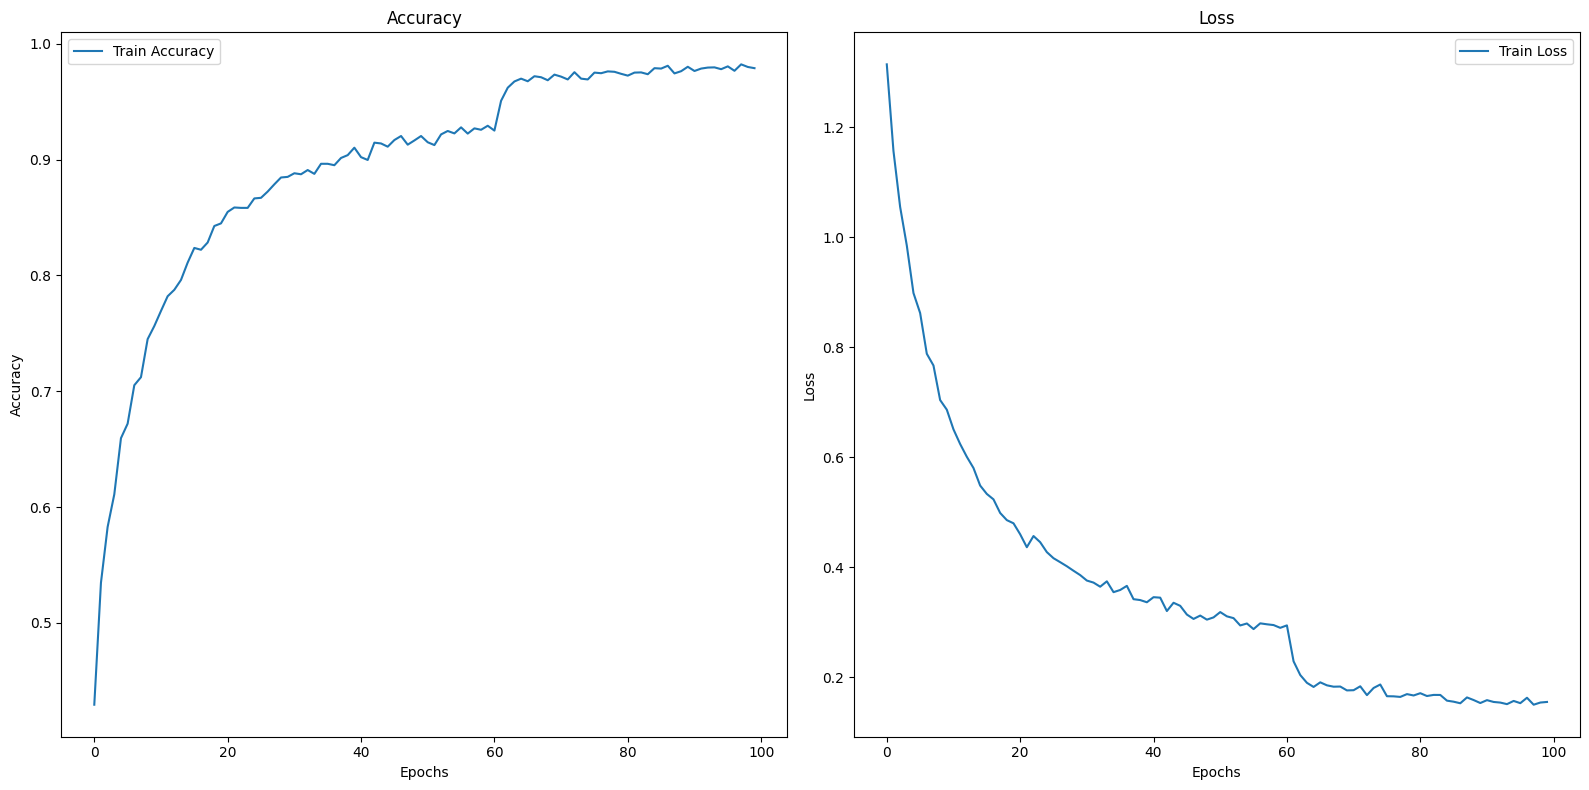

In [11]:
# Cell 10: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # Save the figure as a PNG in the working directory
    plot_save_path = os.path.join(extracted_data_path, 'training_history.png')
    plt.tight_layout()
    plt.savefig(plot_save_path, format='png')  # Explicitly save as PNG
    print(f'Training history plot saved to: {plot_save_path}')

plot_training_history(history)


2024-11-03 10:21:55.163608: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/block1a_bn_1/Cast/ReadVariableOp.
I0000 00:00:1730629315.998242     824 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cb1b54b5496d4fbe:0:0), session_name()


  3/360 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step 

I0000 00:00:1730629325.007430     824 tpu_compile_op_common.cc:245] Compilation of cb1b54b5496d4fbe:0:0 with session name  took 9.009116961s and succeeded
I0000 00:00:1730629325.026926     824 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cb1b54b5496d4fbe:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_15423403217466348464", property.function_library_fingerprint = 7323627967619401433, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730629325.026969     824 tpu_compilation_cache_interface.cc:541] After adding entry for key cb1b54b5496

359/360 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step

I0000 00:00:1730629357.955143     773 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(fd27c90e30d75fa3:0:0), session_name()


360/360 ━━━━━━━━━━━━━━━━━━━━ 58s 120ms/step


I0000 00:00:1730629368.117299     773 tpu_compile_op_common.cc:245] Compilation of fd27c90e30d75fa3:0:0 with session name  took 10.162109259s and succeeded
I0000 00:00:1730629368.135081     773 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(fd27c90e30d75fa3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_8778899009517628189", property.function_library_fingerprint = 15071091306161630933, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,224,224,3,;3,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730629368.135118     773 tpu_compilation_cache_interface.cc:541] After adding entry 

Confusion matrix plot saved to: plots/confusion_matrix.png


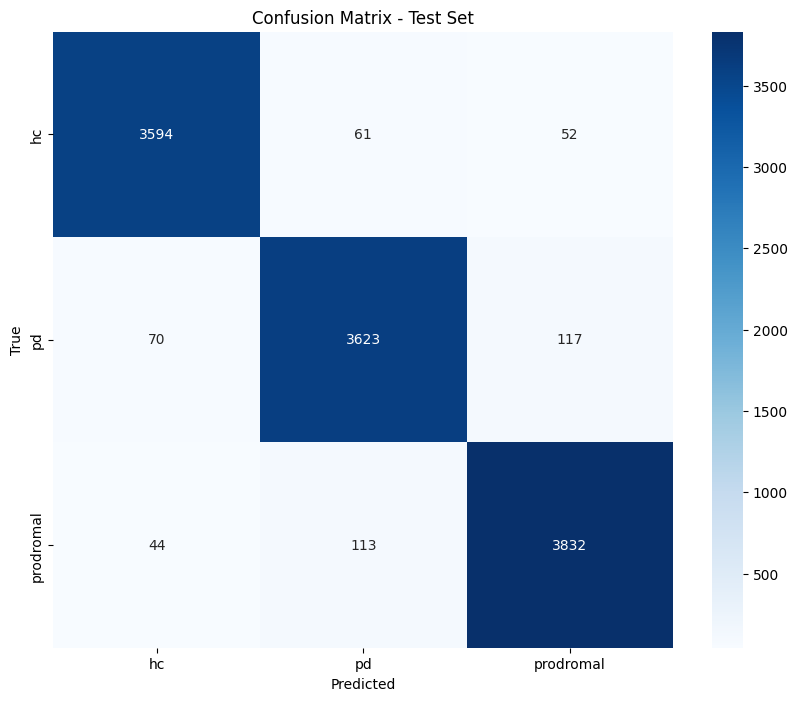

Classification Report:
              precision    recall  f1-score   support

          hc       0.97      0.97      0.97      3707
          pd       0.95      0.95      0.95      3810
   prodromal       0.96      0.96      0.96      3989

    accuracy                           0.96     11506
   macro avg       0.96      0.96      0.96     11506
weighted avg       0.96      0.96      0.96     11506

Test Accuracy: 0.9603
Test F1 Score (Weighted): 0.9603
Test Precision (Weighted): 0.9603
Test Recall (Weighted): 0.9603
ROC curve plot saved to: plots/roc_curve.png


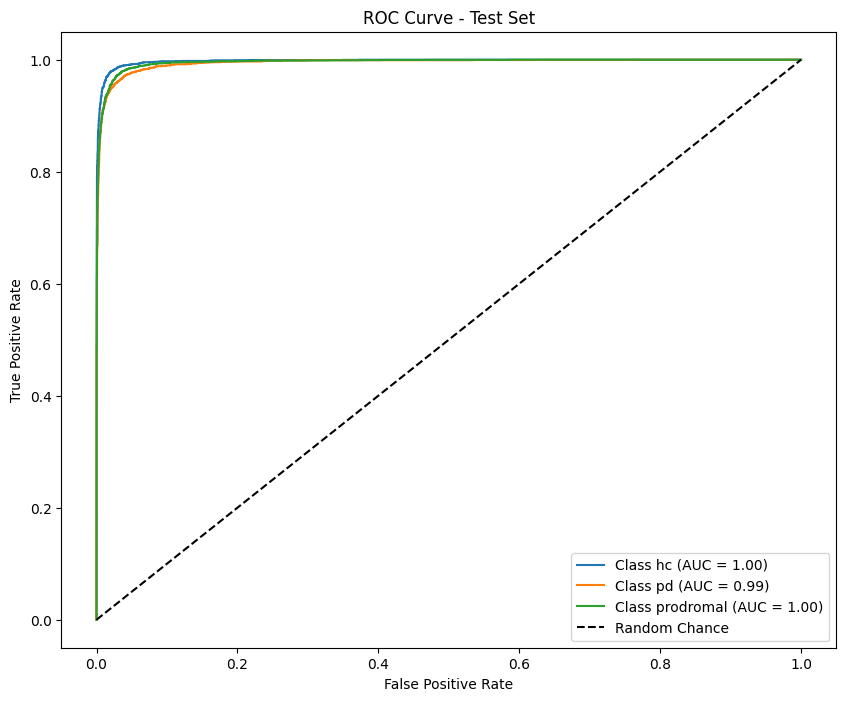

In [12]:
# Cell 11: Generate predictions and classification report, ROC curve, and other metrics
# Define function to evaluate the model
def evaluate_model_on_test_data(model, test_dataset, class_names):
    # Generate predictions on the test dataset
    y_pred_prob = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Extract true labels from the dataset
    y_true = []
    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title('Confusion Matrix - Test Set')

    # Save confusion matrix plot
    plot_save_dir = "plots/"
    if not os.path.exists(plot_save_dir):
        os.makedirs(plot_save_dir)
    confusion_matrix_plot_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
    plt.savefig(confusion_matrix_plot_path)
    print(f"Confusion matrix plot saved to: {confusion_matrix_plot_path}")
    plt.show()

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(f"Classification Report:\n{report}")

    # F1, Precision, Recall, Accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Weighted): {f1:.4f}")
    print(f"Test Precision (Weighted): {precision:.4f}")
    print(f"Test Recall (Weighted): {recall:.4f}")

    # ROC Curve and AUC Score for each class
    y_prob = y_pred_prob
    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc_score(y_true == i, y_prob[:, i]):.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test Set')
    plt.legend()

    # Save ROC plot
    roc_plot_path = os.path.join(plot_save_dir, 'roc_curve.png')
    plt.savefig(roc_plot_path)
    print(f"ROC curve plot saved to: {roc_plot_path}")
    plt.show()

# Call the evaluation function
evaluate_model_on_test_data(model, test_dataset, class_names)


In [13]:
# Cell 11: Generate predictions and classification report, ROC curve, and other metrics, and save all figures

def evaluate_model_on_test_data(model, test_dataset, class_names):
    # Generate predictions on the test dataset
    y_pred_prob = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Extract true labels from the dataset
    y_true = []
    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)

    # Create a directory to save the plots if it doesn't exist
    plot_save_dir = "plots/"
    if not os.path.exists(plot_save_dir):
        os.makedirs(plot_save_dir)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Test Set')
    
    # Save confusion matrix plot
    confusion_matrix_plot_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
    plt.savefig(confusion_matrix_plot_path)
    print(f"Confusion matrix plot saved to: {confusion_matrix_plot_path}")
    plt.close()  # Close the figure to free up memory

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(f"Classification Report:\n{report}")
    
    # Save classification report to a text file
    classification_report_path = os.path.join(plot_save_dir, 'classification_report.txt')
    with open(classification_report_path, 'w') as f:
        f.write(report)
    print(f"Classification report saved to: {classification_report_path}")

    # F1, Precision, Recall, Accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Weighted): {f1:.4f}")
    print(f"Test Precision (Weighted): {precision:.4f}")
    print(f"Test Recall (Weighted): {recall:.4f}")

    # Save these metrics to a text file
    metrics_report_path = os.path.join(plot_save_dir, 'metrics_report.txt')
    with open(metrics_report_path, 'w') as f:
        f.write(f"Test Accuracy: {accuracy:.4f}\n")
        f.write(f"Test F1 Score (Weighted): {f1:.4f}\n")
        f.write(f"Test Precision (Weighted): {precision:.4f}\n")
        f.write(f"Test Recall (Weighted): {recall:.4f}\n")
    print(f"Metrics report saved to: {metrics_report_path}")

    # ROC Curve and AUC Score for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
        auc_score = roc_auc_score(y_true == i, y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test Set')
    plt.legend(loc='lower right')

    # Save ROC curve plot
    roc_plot_path = os.path.join(plot_save_dir, 'roc_curve.png')
    plt.savefig(roc_plot_path)
    print(f"ROC curve plot saved to: {roc_plot_path}")
    plt.close()  # Close the figure to free up memory

    # Additional metrics or plots can be added here and saved similarly

# Call the evaluation function
evaluate_model_on_test_data(model, test_dataset, class_names)


360/360 ━━━━━━━━━━━━━━━━━━━━ 28s 76ms/step
Confusion matrix plot saved to: plots/confusion_matrix.png
Classification Report:
              precision    recall  f1-score   support

          hc       0.97      0.97      0.97      3707
          pd       0.95      0.95      0.95      3810
   prodromal       0.96      0.96      0.96      3989

    accuracy                           0.96     11506
   macro avg       0.96      0.96      0.96     11506
weighted avg       0.96      0.96      0.96     11506

Classification report saved to: plots/classification_report.txt
Test Accuracy: 0.9603
Test F1 Score (Weighted): 0.9603
Test Precision (Weighted): 0.9603
Test Recall (Weighted): 0.9603
Metrics report saved to: plots/metrics_report.txt
ROC curve plot saved to: plots/roc_curve.png
